In [122]:
import matplotlib.pyplot as plt
import numpy as np # convert pictures to Arrays
import pandas as pd
import seaborn as sns
import zipfile
import os
import sys
from datetime import datetime
from wordcloud import WordCloud, STOPWORDS
import warnings
from sklearn.feature_extraction.text import TfidfVectorizer
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from PIL import Image # To read pictures

warnings.filterwarnings('ignore')
#global declaration
FILE_NAME = '\youTubeVideoData_680473'
sns.set()

In [135]:
absolutepath = os.path.dirname(os.path.abspath("__file__"))
print(absolutepath)

fileDirectory = os.path.dirname(absolutepath)
print(fileDirectory)#Path of parent directory
parentDirectory = os.path.dirname(fileDirectory)
print(parentDirectory)
#Navigate to Strings directory
newPath = os.path.join(parentDirectory, 'data', 'raw')   
print(newPath)

C:\Users\jeeva\Documents\GitHub\Recommendation-System-for-YT\notebook\eda
C:\Users\jeeva\Documents\GitHub\Recommendation-System-for-YT\notebook
C:\Users\jeeva\Documents\GitHub\Recommendation-System-for-YT
C:\Users\jeeva\Documents\GitHub\Recommendation-System-for-YT\data\raw


In [136]:
# unzipping the datafile from data raw folder to 
with zipfile.ZipFile(newPath+FILE_NAME+'.zip',"r") as zip_ref:
    zip_ref.extractall(absolutepath)

In [137]:
absolutepath+FILE_NAME

'C:\\Users\\jeeva\\Documents\\GitHub\\Recommendation-System-for-YT\\notebook\\eda\\youTubeVideoData_680473'

In [138]:
df = pd.read_csv(absolutepath+FILE_NAME+'.csv', index_col=0, low_memory=False)

In [148]:
for column in df.columns:
    if (column.find('Count')>0): 
        df[column].replace('[]','0', inplace = True)
        df[column].replace('','0', inplace = True)
        df = df.astype({column:int})
    else:
        df = df.astype({column:str})

In [149]:
df.shape

(680473, 10)

In [150]:
df = df.drop('topicCategories', axis = 1)

KeyError: "['topicCategories'] not found in axis"

In [ ]:
df.dtypes

In [ ]:
(df['favoriteCount'] == 0). sum()

In [ ]:
df.drop('favoriteCount',axis =1, inplace = True)

In [ ]:
#missing value check
df.isnull().sum().sum()

In [ ]:
# df_plot = df.drop(['title'])
count_col = []
for column in df.columns:
    if (column.find('Count')<0):
        count_col.append(column)
df_eda = df.drop(count_col, axis = 1)
df_eda.columns.values
df_eda

In [ ]:
df.head()

In [ ]:
df_eda = df_eda.loc[~df.index.duplicated(), :]

In [ ]:
df_eda

In [151]:
df_eda.describe()
    

,viewCount,likeCount,dislikeCount,commentCount
count,6.804730e+05,6.804730e+05,6.804730e+05,6.804730e+05
mean,8.260607e+05,1.314470e+04,6.392983e+02,6.748293e+02
std,1.042544e+07,1.334828e+05,7.753941e+03,2.853102e+04
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.574000e+03,2.500000e+01,2.000000e+00,2.000000e+00
50%,2.336700e+04,2.980000e+02,1.800000e+01,1.600000e+01
75%,1.707710e+05,2.381000e+03,1.260000e+02,1.100000e+02
max,1.372878e+09,3.104455e+07,1.766148e+06,1.595512e+07


In [152]:
# count_feature = df_eda.select_dtypes(include=['category', int]).columns
# fig, ax = plt.subplots(2, 2, figsize=(25, 10))
# plt.subplots_adjust(hspace = 0.4)
# for col, subplot in zip(count_feature, ax.flatten()):
#     sns.boxplot(x=df_eda[col], ax=subplot)
# plt.show()
# sns.boxplot(data = df_eda['viewCount'])

<Figure size 2160x2160 with 0 Axes>

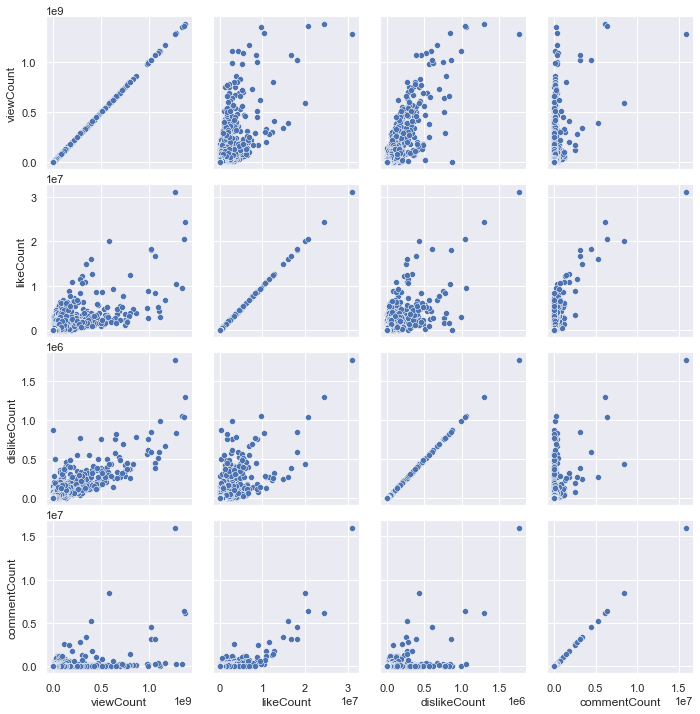

In [153]:
plt.figure(figsize=(30,30)) 
g=sns.PairGrid(df_eda)
g.map(sns.scatterplot)

<AxesSubplot:>

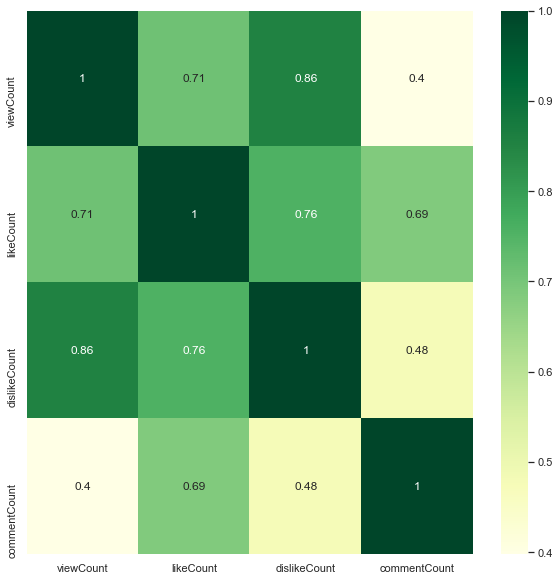

In [154]:
plt.figure(figsize=(10,10)) 
sns.heatmap(df_eda.corr(), annot=True,cmap = 'YlGn')

In [155]:
def pre_process(text):
    
    # lowercase
    text=text.lower()
    
    #remove tags
    text=re.sub("","",text)
    
    # remove special characters and digits
    text=re.sub("(\\d|\\W)+"," ",text)
    
    return text

def get_stop_words(stop_file_path):
    """load stop words """
    
    with open(stop_file_path, 'r', encoding="utf-8") as f:
        stopwords = f.readlines()
        stop_set = set(m.strip() for m in stopwords)
        return frozenset(stop_set)
    
def sort_coo(coo_matrix):
    tuples = zip(coo_matrix.col, coo_matrix.data)
    return sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)

def extract_topn_from_vector(feature_names, sorted_items, topn=5):
    """get the feature names and tf-idf score of top n items"""
    
    #use only topn items from vector
    sorted_items = sorted_items[:topn]

    score_vals = []
    feature_vals = []
    
    # word index and corresponding tf-idf score
    for idx, score in sorted_items:
        
        #keep track of feature name and its corresponding score
        score_vals.append(round(score, 3))
        feature_vals.append(feature_names[idx])

    #create a tuples of feature,score
    #results = zip(feature_vals,score_vals)
    results= {}
    for idx in range(len(feature_vals)):
        results[feature_vals[idx]]=score_vals[idx]
    
    return results

def tfidf(filename, image):
    df = pd.read_csv(filename,index_col=[0])
    print("Data Read")
    df['title'] = df['title'].convert_dtypes()
    df['description'] = df['description'].convert_dtypes()
    df = df.dropna()
    df = df.reset_index(drop=True)
    print("Null values dropped")
    df['text'] = df['title'] + df['description']
    df['text'] = df['text'].apply(lambda x:pre_process(x))
    #load a set of stop words
    stopwords=get_stop_words(r"C:\Users\jeeva\Documents\GitHub\Recommendation-System-for-YT\notebook\Preprocessing\resources\stopwords.txt")

    #get the text column 
    docs=df['text'].tolist()

    #create a vocabulary of words, 
    #ignore words that appear in 85% of documents, 
    #eliminate stop words
    cv=CountVectorizer(max_df=0.85,stop_words=stopwords)
    word_count_vector=cv.fit_transform(docs)
    print(list(cv.vocabulary_.keys())[:10])
    
    tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True)
    tfidf_transformer.fit(word_count_vector)
    # you only needs to do this once, this is a mapping of index to 
    feature_names=cv.get_feature_names()
    i = 0
    tex_list = df['text'].tolist()
    tf_idf_vector_list = []
    for i in range(len(tex_list)):
        tf_idf_vector=tfidf_transformer.transform(cv.transform([tex_list[i]]))
        i = i+1
        tf_idf_vector_list.append(tf_idf_vector)
    print("Tf-idf Generated")
    
    sorted_items_list=[]
    i=0
    for i in range(len(tf_idf_vector_list)):
        sorted_items=sort_coo(tf_idf_vector_list[i].tocoo())
        i = i+1
        sorted_items_list.append(sorted_items)
    print("Sorting Complete")
    keyword_list = []
    i=0
    for i in range(len(sorted_items_list)):
        keywords=extract_topn_from_vector(feature_names,sorted_items_list[i],5)
        i = i+1
        keyword_list.append(keywords)
    print("Top 5 extraction done")
    count_list = []
    comment_words=''
    for i  in range(len(keyword_list)):
        for k in keyword_list[i]:
            count_list.append(k)
            if((i%10000)==0):
                print("Keywords added",i)
            comment_words += "".join(k)+" "
    print("To keywords text file create")
    
    mask = np.array(Image.open(image))# Path for Image of the state
    wordcloud = WordCloud(width = 2000, height = 1600,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 5,
                mask = mask,
                collocations=False).generate(comment_words)
 
    # plot the WordCloud image                      
    plt.figure(figsize = (8, 8), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)

    plt.imshow(wordcloud, interpolation='bilinear')

In [ ]:
filename = r"C:\Users\jeeva\Documents\GitHub\Recommendation-System-for-YT\data\raw\StateWise-Data\TamilNadu\youTubeSearchListTamilNadu.csv"
image = r'C:\Users\jeeva\Documents\GitHub\Recommendation-System-for-YT\notebook\eda\download.png'

Data Read
Null values dropped
['learn', 'drama', 'kdrama', 'koreandrama', 'kcdrama', 'koreanwords', 'annyeong', 'kdramagirls', 'hello', 'lovers']
Tf-idf Generated
Sorting Complete
Top 5 extraction done
Keywords added 0
Keywords added 0
Keywords added 0
Keywords added 0
Keywords added 0
Keywords added 10000
Keywords added 10000
Keywords added 10000
Keywords added 10000
Keywords added 10000
Keywords added 20000
Keywords added 20000
Keywords added 20000
Keywords added 20000
Keywords added 20000
Keywords added 30000
Keywords added 30000
Keywords added 30000
Keywords added 30000
Keywords added 30000
Keywords added 40000
Keywords added 40000
Keywords added 40000
Keywords added 40000
Keywords added 40000
Keywords added 50000
Keywords added 50000
Keywords added 50000
Keywords added 50000
Keywords added 50000
Keywords added 60000
Keywords added 60000
Keywords added 60000
Keywords added 60000
Keywords added 60000
Keywords added 70000
Keywords added 70000
Keywords added 70000
Keywords added 70000

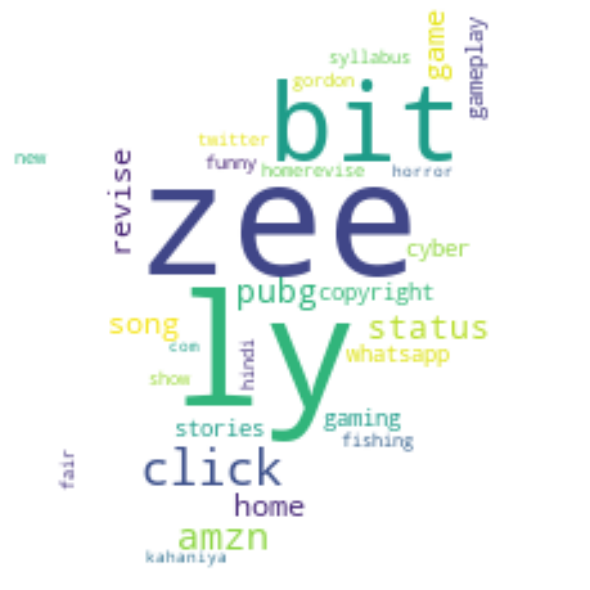

In [156]:
tfidf(r"C:\Users\jeeva\Documents\GitHub\Recommendation-System-for-YT\data\raw\StateWise-Data\TamilNadu\youTubeSearchListTamilNadu.csv")

In [ ]:
# Just try two things to improve ths try to get high res images of states and have increase the wordcounts

In [ ]:
#No we need o have different paths for different images of the stated and then we can call them for a specific action

In [ ]:
# The bottom part is not needed anymore

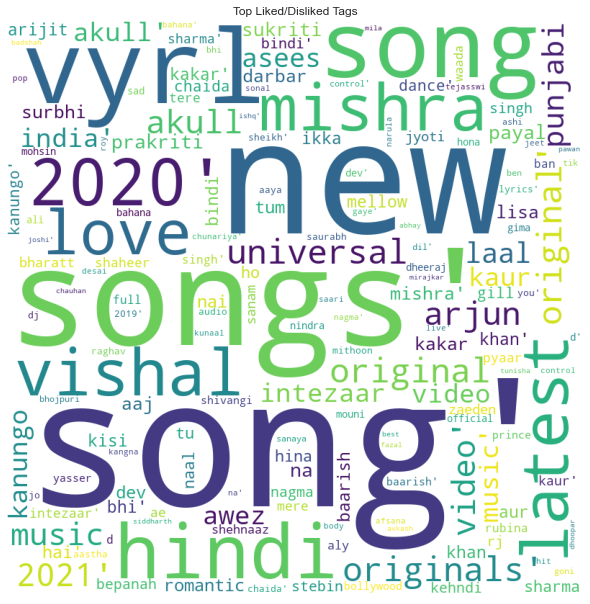

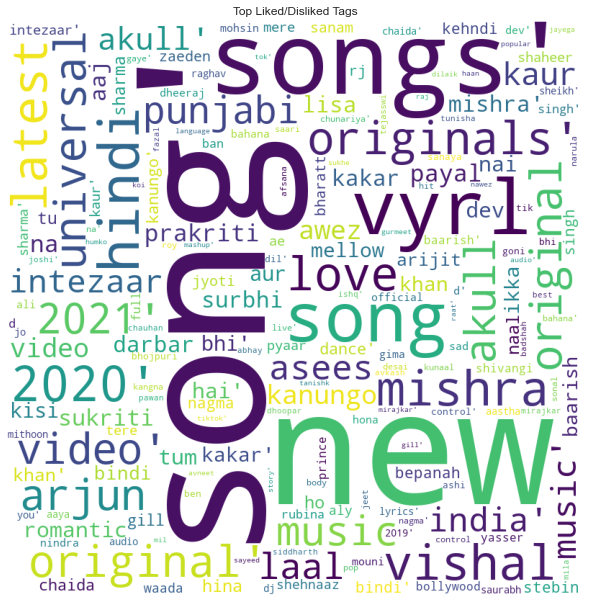

In [46]:
# word count
def pre_process(text):
    
    # lowercase
    text=text.lower()
    
    #remove tags
    text=re.sub("","",text)
    
    # remove special characters and digits
    text=re.sub("(\\d|\\W)+"," ",text)
    
    return text

def get_stop_words(stop_file_path):
    """load stop words """
    
    with open(stop_file_path, 'r', encoding="utf-8") as f:
        stopwords = f.readlines()
        stop_set = set(m.strip() for m in stopwords)
        return frozenset(stop_set)
    
def sort_coo(coo_matrix):
    tuples = zip(coo_matrix.col, coo_matrix.data)
    return sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)

def extract_topn_from_vector(feature_names, sorted_items, topn=5):
    """get the feature names and tf-idf score of top n items"""
    
    #use only topn items from vector
    sorted_items = sorted_items[:topn]

    score_vals = []
    feature_vals = []
    
    # word index and corresponding tf-idf score
    for idx, score in sorted_items:
        
        #keep track of feature name and its corresponding score
        score_vals.append(round(score, 3))
        feature_vals.append(feature_names[idx])

    #create a tuples of feature,score
    #results = zip(feature_vals,score_vals)
    results= {}
    for idx in range(len(feature_vals)):
        results[feature_vals[idx]]=score_vals[idx]
    
    return results

def tfidf(filename):
    df = pd.read_csv(filename,index_col=[0])
    print("Data Read")
    df['title'] = df['title'].convert_dtypes()
    df['description'] = df['description'].convert_dtypes()
    df = df.dropna()
    df = df.reset_index(drop=True)
    print("Null values dropped")
    df['text'] = df['title'] + df['description']
    df['text'] = df['text'].apply(lambda x:pre_process(x))
    #load a set of stop words
    stopwords=get_stop_words(r"C:\Users\jeeva\Documents\GitHub\Recommendation-System-for-YT\notebook\Preprocessing\resources\stopwords.txt")

    #get the text column 
    docs=df['text'].tolist()

    #create a vocabulary of words, 
    #ignore words that appear in 85% of documents, 
    #eliminate stop words
    cv=CountVectorizer(max_df=0.85,stop_words=stopwords)
    word_count_vector=cv.fit_transform(docs)
    print(list(cv.vocabulary_.keys())[:10])
    
    tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True)
    tfidf_transformer.fit(word_count_vector)
    # you only needs to do this once, this is a mapping of index to 
    feature_names=cv.get_feature_names()
    i = 0
    tex_list = df['text'].tolist()
    tf_idf_vector_list = []
    for i in range(len(tex_list)):
        tf_idf_vector=tfidf_transformer.transform(cv.transform([tex_list[i]]))
        i = i+1
        tf_idf_vector_list.append(tf_idf_vector)
    print("Tf-idf Generated")
    
    sorted_items_list=[]
    i=0
    for i in range(len(tf_idf_vector_list)):
        sorted_items=sort_coo(tf_idf_vector_list[i].tocoo())
        i = i+1
        sorted_items_list.append(sorted_items)
    print("Sorting Complete")
    keyword_list = []
    i=0
    for i in range(len(sorted_items_list)):
        keywords=extract_topn_from_vector(feature_names,sorted_items_list[i],5)
        i = i+1
        keyword_list.append(keywords)
    print("Top 5 extraction done")
    count_list = []
    comment_words=''
    for i  in range(len(keyword_list)):
        for k in keyword_list[i]:
            count_list.append(k)
            if((i%10000)==0):
                print("Keywords added",i)
            comment_words += "".join(k)+" "
    print("To keywords text file create")
    mask = np.array(Image.open(r'C:\Users\jeeva\Documents\GitHub\Recommendation-System-for-YT\notebook\eda\download.png'))
    wordcloud = WordCloud(width = 2000, height = 1600,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 5,
                mask = mask,
                collocations=False).generate(comment_words)
 
    # plot the WordCloud image                      
    plt.figure(figsize = (8, 8), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)

    plt.imshow(wordcloud, interpolation='bilinear')

In [ ]:
# word count
i = 0
for i in range(2):
    if i == 0:
        df_eda.sort_values(['likeCount'], ascending=False,axis=0,inplace=True)
    else:
        df_eda.sort_values(['dislikeCount'], ascending=False,axis=0,inplace=True)
    
    comment_words = ''
    stopwords = set(STOPWORDS)
    
    # iterate through the csv file
    for val in df.title.iloc[0:10000]:
         
        # typecaste each val to string
        val = str(val)
     
        # split the value
        tokens = val.split()
        
        # Converts each token into lowercase
        for i in range(len(tokens)):
            tokens[i] = tokens[i].lower()
         
        comment_words += " ".join(tokens)+" "
      
    wordcloud = WordCloud(width = 800, height = 800,
                    background_color ='white',
                    stopwords = stopwords,
                    
                    min_font_size = 10).generate(comment_words)
     
    # plot the WordCloud image                      
    plt.figure(figsize = (8, 8), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)
    plt.title('Top Liked/Disliked Titles')
     
plt.show()

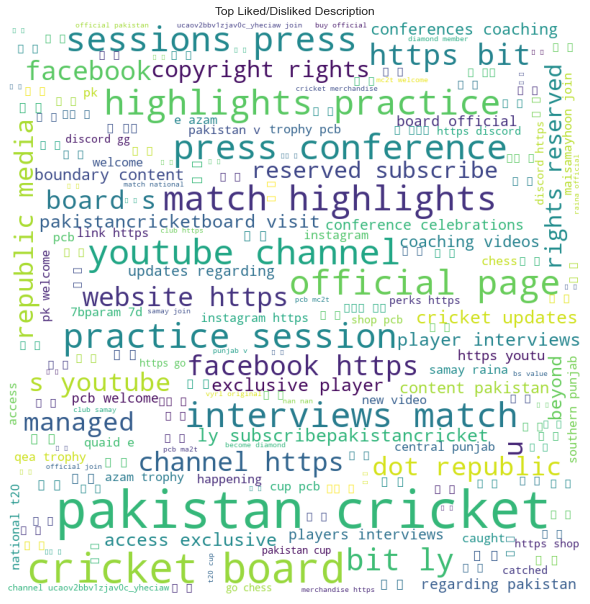

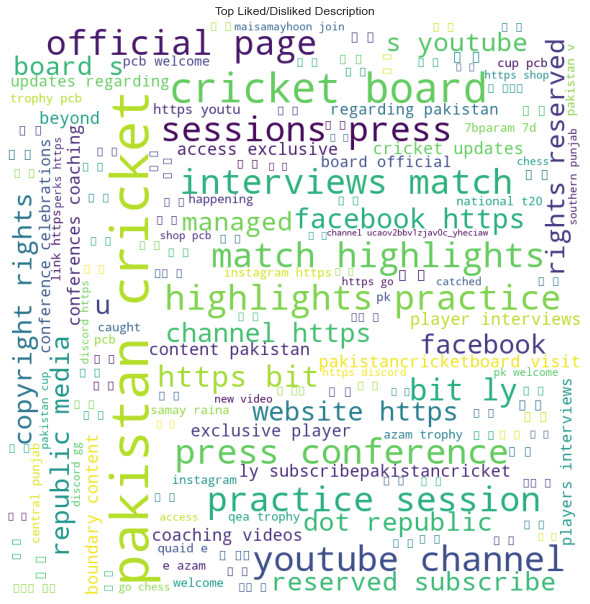

In [30]:
# word count
i = 0
for i in range(2):
    if i == 0:
        df_eda.sort_values(['likeCount'], ascending=False,axis=0,inplace=True)
    else:
        df_eda.sort_values(['dislikeCount'], ascending=False,axis=0,inplace=True)
    
    comment_words = ''
    stopwords = set(STOPWORDS)
    
    # iterate through the csv file
    for val in df.description.iloc[0:10000]:
         
        # typecaste each val to string
        val = str(val)
     
        # split the value
        tokens = val.split()
        
        # Converts each token into lowercase
        for i in range(len(tokens)):
            tokens[i] = tokens[i].lower()
         
        comment_words += " ".join(tokens)+" "
     
    wordcloud = WordCloud(width = 800, height = 800,
                    background_color ='white',
                    stopwords = stopwords,
                    min_font_size = 10).generate(comment_words)
     
    # plot the WordCloud image                      
    plt.figure(figsize = (8, 8), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)
    plt.title('Top Liked/Disliked Description')
         
plt.show()

In [ ]:
# TODO: Tentative
#topic categories.
#topic modeling..
#datetime fromatting